### Business Understanding

Onderzoeksvraag:
Kan er een voorspelling worden gedaan over de vertragingstijd om treinverkeersleiders efficiënter de treinplanning te hervatten.




-------------------------------------

### Data Understanding
Van ProRail hebben we een [data dictionary](https://canvas.hu.nl/courses/27143/pages/data?module_item_id=588747) gekregen.
Hierin staan alle kolommen uit de dataset met een beschrijving over de kolom indien van toepassing.

We beginnen met een aantal modules te importeren om de data te analyseren.

In [1]:
import numpy as np
import pandas as pd

import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

from scipy.interpolate import interp1d


import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)

pd.options.display.max_columns = None
pd.options.display.max_rows = 1000

%matplotlib inline

#### Dataset inladen
Ten eerste laden we het csv-bestand in.

In [2]:
dataset_complete = pd.read_csv("sap_storing_data_hu_project.csv", low_memory=False)

In [28]:
# todo later verwijderen en hele dataset pakken
# 10% (1 jaar +- aan datapunten) van data inladen is tijdelijk, om efficiënter te werk te gaan tijdens de onderzoek fase
ten_percent = int(dataset_complete.shape[0]*.1)
dataset = dataset_complete.sample(ten_percent, random_state=0)

We bekijken de eerste paar rijen om een eerste inzicht te krijgen over de daadwerkelijke data.

In [29]:
dataset.head()

,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_mon_meld_ddt,stm_sap_meldtekst_lang,stm_mon_begin_ddt,stm_sap_meldtekst,stm_mon_toelichting_trdl,stm_oh_pg_mld,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_equipm_nr_mld,stm_equipm_soort_mld,stm_equipm_omschr_mld,stm_km_van_mld,stm_km_tot_mld,stm_prioriteit,stm_scenario_mon,stm_status_melding_sap,stm_mon_nr_status_omschr,stm_mon_nr__statuscode,stm_mon_nr_status_wijzdd,stm_aanngeb_ddt,stm_aanntpl_ddt,stm_oh_pg_gst,stm_geo_gst,stm_geo_gst_uit_functiepl,stm_equipm_nr_gst,stm_equipm_soort_gst,stm_equipm_omschr_gst,stm_objectdl_code_gst,stm_objectdl_groep_gst,stm_km_van_gst,stm_km_tot_gst,stm_progfh_in_ddt,stm_progfh_in_invoer_ddt,stm_progfh_gw_ddt,stm_progfh_gw_lwd_ddt,stm_progfh_hz,stm_oorz_groep,stm_oorz_code,stm_oorz_tkst,stm_veroorz_groep,stm_veroorz_code,stm_veroorz_tekst_kort,stm_effect,stm_afspr_aanvangddt,stm_fh_ddt,stm_fh_status,stm_sap_storeind_ddt,stm_mon_eind_ddt,stm_mon_vhdsincident,stm_tao_indicator,stm_tao_indicator_vorige,stm_tao_soort_mutatie,stm_tao_telling_mutatie,stm_tao_beinvloedbaar_indicator,stm_evb,stm_dir_betrok_tr,stm_aangelegd_dd,stm_aangelegd_tijd,stm_sap_melddatum,stm_sap_meldtijd,stm_mon_begindatum,stm_mon_begintijd,stm_contractgeb_mld,stm_functiepl_mld,stm_techn_mld,stm_contractgeb_gst,stm_functiepl_gst,stm_techn_gst,stm_aanngeb_dd,stm_aanngeb_tijd,stm_aanntpl_dd,stm_aanntpl_tijd,stm_arbeid,stm_progfh_in_datum,stm_progfh_in_tijd,stm_progfh_in_invoer_dat,stm_progfh_in_invoer_tijd,stm_progfh_in_duur,stm_progfh_gw_datum,stm_progfh_gw_tijd,stm_progfh_gw_lwd_datum,stm_progfh_gw_lwd_tijd,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_reactie_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_mon_eind_datum,stm_mon_eind_tijd,stm_controle_dd,stm_akkoord_mon_toewijz,stm_status_sapnaarmon,stm_fact_jn,stm_akkoord_melding_jn,stm_afsluit_ddt,stm_afsluit_dd,stm_afsluit_tijd,stm_rec_toegev_ddt,stm_hinderwaarde,stm_actie,stm_standplaats,stm_status_gebr,stm_wbi_nummer,stm_projnr,stm_oorz_tekst_kort,stm_historie_toelichting,stm_schade_verhaalb_jn,stm_schadenr,stm_schade_status_ga,stm_schade_statusdatum,stm_relatiervo_vorig,stm_relatiervo_volgend,stm_relatiervo,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar,stm_afspr_func_hersteldd,stm_afspr_func_hersteltijd,stm_sorteerveld,stm_rapportage_maand,stm_rapportage_jaar,stm_x_bron_publ_dt,stm_x_bron_bestandsnaam,stm_x_bron_arch_dt,stm_x_actueel_ind,stm_x_run_id,stm_x_bk,stm_x_start_sessie_dt,stm_x_vervallen_ind
592816,599985,80749741,0.0,NaN,12/01/2014 14:10:00,12/01/2014 14:10:00,Rtd : Omroep te hard.,NaN,Rtd : Omroep te hard.,NaN,03T,555,555.0,11293780.0,OMROEPHP,Rtd Omroep Hoofdpost,84200.0,0.0,5.0,NaN,MAFS,NaN,NaN,00/00/0000,12/01/2014 14:10:00,13/01/2014 09:50:00,03T,555.0,555.0,10763622.0,OMROEPOP,Rtd Omroep OP,NaN,NaN,84200.0,0.0,13/01/2014 10:50:00,13/01/2014 09:50:58,NaN,NaN,Z,TECHONV,218.0,bij onderzoek geen onregelmatigheden aangetro...,NaN,NaN,NaN,NaN,NaN,13/01/2014 10:29:00,4.0,13/01/2014 10:30:00,NaN,NaN,N,NaN,NaN,0,B,"0,00",NaN,12/01/2014,14:10:20,12/01/2014,14:10:00,NaN,NaN,3.0,555-802-1000115114,T,3.0,555-802-1000115114,T,12/01/2014,14:10:00,13/01/2014,09:50:00,39.0,13/01/2014,10:50:00,13/01/2014,09:50:58,60,NaN,00:00:00,NaN,NaN,99999999,0.0,00/00/0000,00:00:00,13/01/2014,10:29:00,1219.0,1.180000e+03,13/01/2014,10:30:00,NaN,NaN,21/01/2014,NaN,NaN,J,2.0,NaN,07:53:54,12/01/20,NaN,50.0,0.0,IN5,NaN,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13/01/2014,12:00:00,NaN,NaN,1,2014,13/01/2014 01:00:21,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,02/06/2014 05:30:02,0,15325,2526857,23/01/2014 08:47:08,0
680751,688480,80794767,0.0,NaN,30/01/2015 17:32:00,30/01/2015 17:32:00,ss kamp : O spanning 230V en 48V.,NaN,ss kamp : O spanning 230V en 48V.,NaN,11E,161,161.0,11472994.0,LBDV,SS Kamp Lokale bedr. Voer. Instal,31900.0,0.0,2.0,NaN,MAFS,NaN,NaN,00/00/0000,30/01/2015 17:32:00,30/01/2015 18:46:00,11E,16

Bekijken van het aantal datapunten en kolommen in de data.

In [30]:
rows, cols = dataset.shape
print(f'De dataset bevat {rows} rijen en {cols} kolommen')

De dataset bevat 89852 rijen en 140 kolommen


#### Interessante kolommen om de target variabele te construeren.
We gaan eerst de kolommen analyseren die mogelijk van toepassing kunnen zijn bij het bepalen van een target variabele voor de onderzoeksvraag.

Hiervoor gebruiken we het tijdstip van de functieherstel.
Functieherstel tijdstip is het moment dat een storing is opgelost, maar het treinverkeer nog niet per definitie hervat is.
De functieherstel duur is de tijd vanaf de initiële melding tot de tijdstip van functieherstel.

Volgens het interview met ProRail is het vaak lastig om te bepalen hoelang het duurt voordat een aanemer ter plaatse is om een storing te verhelpen.
Om deze reden is de duur van de complete storing (functieherstel duur) lastig te voorspellen. Daarom kijken we ook naar de tijd dat de aannemer ter plaatse is. De duur van dit tijdstip tot het tijdstip van de functieherstel tijd is interessant om te onderzoeken, omdat vanaf het moment dat de aannemer aanwezig is er **waarschijnlijk** meer te zeggen valt over hoelang de vertraging nog duurt.

Ook heeft ProRail ons laten weten dat ze het vooral interessant vinden om storingen te bekijken/voorspellen die niet langer duren dan een werkdag.

Voor de meld-, aannemer-ter-plaatse- en functiehersteltijd zijn 2 verschillende kolommen aanwezig in de data dictionary. Laten we ze allemaal bekijken om het verschil te zien.
Er lijkt ook een herstelduur te staan in de data dictionary maar met een '?' erbij we gaan er vanuit dat dit niet een correcte functieherstel duur is en we zelf de herstelduur gaan berekenen.

In [31]:
target_selection = ['stm_sap_meldtijd','stm_sap_meld_ddt', 'stm_aanntpl_tijd', 'stm_aanntpl_ddt', 'stm_fh_tijd', 'stm_fh_ddt','stm_fh_duur']

In [32]:
dataset[target_selection].sample(10, random_state=2)

,stm_sap_meldtijd,stm_sap_meld_ddt,stm_aanntpl_tijd,stm_aanntpl_ddt,stm_fh_tijd,stm_fh_ddt,stm_fh_duur
861252,17:38:45,08/02/2018 17:38:45,20:35:01,08/02/2018 20:35:01,22:51:01,08/02/2018 22:51:01,312.0
408503,12:45:00,06/11/2010 12:45:00,12:47:00,06/11/2010 12:47:00,13:07:00,06/11/2010 13:07:00,22.0
741181,12:13:40,01/02/2016 12:13:40,02:00:00,02/02/2016 02:00:00,06:40:00,03/02/2016 06:40:00,2546.0
35918,10:34:00,07/02/2013 10:34:00,00:00:00,NaN,00:00:00,NaN,0.0
361408,12:18:00,14/10/2009 12:18:00,12:30:00,14/10/2009 12:30:00,12:59:00,14/10/2009 12:59:00,41.0
125336,07:35:00,04/05/2018 07:35:00,00:00:00,NaN,00:00:00,NaN,0.0
453484,11:01:00,17/11/2011 11:01:00,11:47:00,17/11/2011 11:47:00,14:09:00,17/11/2011 14:09:00,179.0
677282,20:24:00,12/01/2015 20:24:00,00:00:00,NaN,21:54:00,14/01/2015 21:54:00,2970.0
351136,07:11:00,06/07/2009 07:11:00,08:21:00,06/07/2009 08:21:00,08:24:00,06/07/2009 08:24:00,10.0
1111,12:10:00,15/04/2006 12:10:00,00:00:00,NaN,13:15:00,15/04/2006 13:15:00,65.0


Opvallend is dat de functieherstel duur in veel gevallen aanzienlijk langer is dan de duur tussen het tijdstip dat de aannemer ter plaatse is en het functieherstel tijdstip.

De kolommen eindigend op ddt bevatten een datum en tijd in Dag/Maand/Jaar Uur:Minuten:Seconden.
En de kolommen eindigend op tijd bevatten alleen de tijd in Uur:Minuten:Seconden.

Wat ook opvalt is dat de kolommen eindigend met ddt NaN waardes bevat maar op eerste blik alleen bij rijen waar de functieherstel duur 0 is of wanneer de aannemer ter plaatse tijd 00:00:00 is. Dit duidt erop dat NaN waardes die altijd gecombineerd lijken te zijn met een tijdstip 00:00:00 alleen in rijen voorkomt waar er geen aannemer ter plaatse nodig was om de storing te verhelpen.

### Meetniveau

De target variabele kolom is nog niet aanwezig maar dit zal in dezelfde eenheid zijn als functieherstel duur, namelijk duur in minuten.

Minuten zijn van een continue meetniveau omdat je tot oneindige precisie tussen 2 verschillende waardes in minuten kan meten

### Centrum- en spreidingsmaten

In [33]:
dataset['stm_fh_duur'].describe().round()

count     89851.0
mean        936.0
std        6510.0
min           0.0
25%          11.0
50%          83.0
75%         256.0
max      525621.0
Name: stm_fh_duur, dtype: float64

In de tabel hierboven is te zien:
- Aantal observaties
- Gemiddelde
- Standaardafwijking
- Minimale observatie
- 25% (Kwartiel 1)
- 50% (Kwartiel 2, ookwel de mediaan)
- 75% (Kwartiel 3)
- Maximale observatie

We kunnen hier uit een aantal dingen opmerken:
- Groot verschil tussen min en max observaties.
- Het gemiddelde ligt veel hoger dan de mediaan, dit duidt op uitschieters.
- Minimale observatie is 0: dit zouden storingen kunnen zijn die niet voor vertraging zorgen (zoals een ICT storing).
- Grote standaardafwijking: dit duidt erop dat de observaties breed verdeeld zijn om het gemiddelde.

Om een visuele blik te krijgen op de verdeling van de data plotten we een histogram.

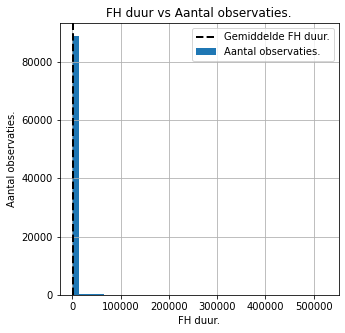

In [34]:
dataset[target_selection].hist(figsize=(5,5), bins=40) # hist
plt.axvline(dataset['stm_fh_duur'].mean(), color='black', linestyle='dashed', linewidth=2) # add mean line
plt.legend(["Gemiddelde FH duur.", "Aantal observaties."], loc="upper right") # legend
plt.title("FH duur vs Aantal observaties."), plt.xlabel("FH duur."), plt.ylabel("Aantal observaties.") # title, x & y labels

plt.show()

Zoals te zien en omschreven bij de describe is de FH duur erg verspreidt en bevat outliers die de histogram onleesbaar maakt.

Laten we daarom opnieuw een histogram plotten die alleen naar storingen kijkt die binnen de acceptabele marge (6 uur volgens ProRail) zijn opgelost en die voor een vertraging hebben gezorgd (FH duur groter zijn dan 0). Dit zijn volgens ProRail de meest interessante storingen om een voorspellingen over te kunnen doen.

In [35]:
zero_360_filter = (dataset['stm_fh_duur'] > 0) & (
            dataset['stm_fh_duur'] <= 360)  # boolean mask to filter on FH > 0 and <= 360.

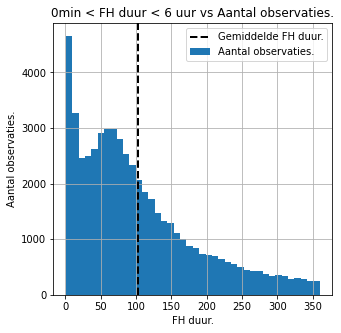

In [36]:
dataset[zero_360_filter][target_selection].hist(figsize=(5,5), bins = 40)# hist
plt.axvline(dataset[zero_360_filter]['stm_fh_duur'].mean(), color='black', linestyle='dashed', linewidth=2) # add mean line
plt.legend(["Gemiddelde FH duur.", "Aantal observaties."], loc="upper right") # legend
plt.title("0min < FH duur < 6 uur vs Aantal observaties."), plt.xlabel("FH duur."), plt.ylabel("Aantal observaties.") # title, x & y labels

plt.show()

FH duur boven de 0 minuten en tot en met 6 uur, heeft een rechtscheve verdeling.

#### Uitschieters

Om een visueel beeld te krijgen van de spreiding/uitschieters van de functieherstel duur wordt deze getoond in een boxplot.

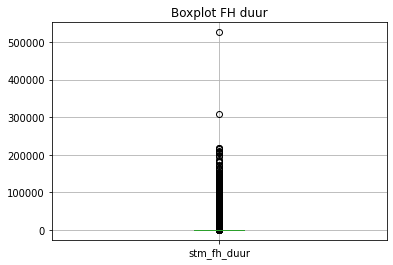

In [37]:
dataset.boxplot('stm_fh_duur')
plt.title("Boxplot FH duur")
plt.show()

Er zijn erg veel extreem hoge uitschieters terwijl het mediaan laag ligt.
Om een beter overzicht te krijgen, kijken we in een nieuwe boxplot alleen naar functieherstel duur boven de 0 en onder de 360 minuten.

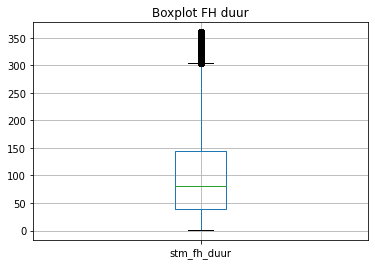

In [38]:
dataset[zero_360_filter].boxplot('stm_fh_duur')
plt.title("Boxplot FH duur")
plt.show()

Er liggen alleen uitschieters aan de rechterkant.
De maximale niet-uitschieter is ongeveer 300 minuten en de kleinste niet uitschieter 1 minuut.
De helft van de vertagingen tussen 1 en 360 minuten valt binnen ongeveer 40 en 145 minuten.

### Data Preparation
Als eerst gaan we een kolom maken voor de functieherstel duur en de target kolom, functieherstel duur vanaf het moment dat de aannemer ter plaatse is.


In [81]:
df_target = dataset.copy()

#### NA waardes
Eerst controleren we op lege velden, ofwel NaN waarden.

In [82]:
df_target[target_selection].isna().sum()

stm_sap_meldtijd        1
stm_sap_meld_ddt        0
stm_aanntpl_tijd        1
stm_aanntpl_ddt     20926
stm_fh_tijd             1
stm_fh_ddt          16599
stm_fh_duur             1
dtype: int64

Alleen de kolommen aannemer ter plaatse ddt en functie herstel ddt bevatten een merkwaardig aantal NaN waardes.
Laten we kijken hoeveel van deze NaN waardes overeen komen met een functieherstel tijd van 0 minuten. En ook hoeveel er overeen komen met een aannemer ter plaatse tijdstip van 00:00:00 omdat dit in de data understanding fase opviel.

In [83]:
(df_target['stm_aanntpl_tijd'] == '00:00:00').sum()

20990

Bijna alle aannemer ter plaatse tijdstippen komen overeen met 00:00:00 waar der een NaN is voor de ddt variant van de kolom.

In [84]:
(df_target['stm_fh_duur'] == 0).sum()

17206

Deze datapunten zijn niet van belang bij het maken van een voorspelling, dus zullen we uit onze dataset verwijderen.

In [85]:
df_target.dropna(subset=target_selection, inplace=True)

In [88]:
df_target[target_selection].isna().sum()

stm_sap_meldtijd    0
stm_sap_meld_ddt    0
stm_aanntpl_tijd    0
stm_aanntpl_ddt     0
stm_fh_tijd         0
stm_fh_ddt          0
stm_fh_duur         0
dtype: int64

##### Duplicate rijen
Daarnaast moeten we controleren of we te maken hebben met duplicate rijen, ofwel rijen die meerdere keren in de dataset staan.

In [89]:
df_target.duplicated().sum()

0

We hebben niet te maken met duplicates. Hier hoeven we dus niets mee te doen.We hebben niet te maken met duplicates. Hier hoeven we dus niets mee te doen.

In [90]:
df_target[target_selection] = df_target[target_selection].drop_duplicates()

##### Dtypes
We controleren de datatypes en zetten deze om waar dat nodig is.

In [91]:
df_target[target_selection].dtypes

stm_sap_meldtijd     object
stm_sap_meld_ddt     object
stm_aanntpl_tijd     object
stm_aanntpl_ddt      object
stm_fh_tijd          object
stm_fh_ddt           object
stm_fh_duur         float64
dtype: object

Zoals te zien zijn de data en tijden momenteel objecten. We veranderen alle dtypes van tijd en datum kolommen naar een datetime datatype. Dit doen we door gebruik te maken van een lambda die controleert of 'ddt' in de kolomnaam zit.

In [92]:
ddt_cols = list(filter(lambda x: 'ddt' in x, dataset.columns)) # filter columns on containing 'ddt' in their name
df_target[ddt_cols] = df_target[ddt_cols].apply(lambda ddt_col: pd.to_datetime(ddt_col, format='%d/%m/%Y %H:%M:%S', errors='coerce')) # apply to_datetime to every ddt column

In [93]:
tijd_cols = list(filter(lambda x: 'tijd' in x, dataset.columns))
df_target[tijd_cols] = df_target[tijd_cols].apply(lambda tijd_col: pd.to_datetime(tijd_col,format= '%H:%M:%S', errors='coerce').dt.time)

In [74]:
df_target[target_selection].dtypes # note just the timestamps in H:M:S stay a object but is actually a time object

stm_sap_meldtijd            object
stm_sap_meld_ddt    datetime64[ns]
stm_aanntpl_tijd            object
stm_aanntpl_ddt     datetime64[ns]
stm_fh_tijd                 object
stm_fh_ddt          datetime64[ns]
stm_fh_duur                float64
dtype: object

In [95]:
df_target[target_selection].isna().sum()

stm_sap_meldtijd    3623
stm_sap_meld_ddt    3619
stm_aanntpl_tijd    3619
stm_aanntpl_ddt     3619
stm_fh_tijd         3619
stm_fh_ddt          3619
stm_fh_duur         3619
dtype: int64

In [98]:
df_target.dropna(subset=target_selection, inplace=True)

De benodigde kolommen hebben nu kloppende datatypes. Hoewel er bij tijden, zoals bijvoorbeeld stm_sap_meldtijd, nog steeds 'object' staat, zijn deze nu wel te manipuleren met bijvoorbeeld sorteerfuncties.

We kunnen nu de kolommen maken voor functieherstel duur, en de functieherstel duur vanaf het moment dat de aannemer ter plaatse is (onze target).

In [99]:
df_target['aanntpl_fh_duur'] = ((df_target['stm_fh_ddt'] - df_target['stm_aanntpl_ddt']).dt.total_seconds() / 60).astype('int')
df_target['fh_duur'] = ((df_target['stm_fh_ddt'] - df_target['stm_sap_meld_ddt']).dt.total_seconds() / 60).astype('int')

In [100]:
df_target[['fh_duur', 'aanntpl_fh_duur']]

,fh_duur,aanntpl_fh_duur
592816,1219,39
680751,108,34
760628,235,235
237571,116,52
849077,103,33
...,...,...
819633,255,109
482955,34,3
601257,74,35
490991,18,3


#### Uitschieters

Zoals eerder beschreven tijdens de data understanding fase heeft ProRail laten weten vooral geïnteresseerd te zijn in de vertragingen waarvan de oorzakende storing maximaal één werkdag lang is.

Daarom halen we alle rijen weg die **niet** een functieherstel duur hebben van kleiner dan of gelijk aan 360 minuten (6 uur).
Hiermee wordt gelijk een groot gedeelte van de uitschieters verwijderd.

In [101]:
df_target = df_target[(df_target['fh_duur'] <= 360) & (df_target['stm_fh_duur'] <= 360)]

Omdat niet elk model gevoelig is voor uitschieters laten we de uitschieters die zijn overgebleven in de data zitten.
De overgebleven outliers worden behandeld indien nodig voor een desbetreffend model tijdens de modelleringsfase.

Ook worden alle rijen met een functieherstel tijd van 0 minuten verwijderd omdat dit geen vertragingen zijn.

In [102]:
df_target = df_target[(df_target['fh_duur'] > 0) & (df_target['stm_fh_duur'] > 0)]

Als target willen we bepalen de duur van het moment dat een aannemer ter plaatse is tot het moment dat de functieherstel is afgerond.

Het is handig om eerst te controleren of de aanntpl ddt altijd eerder is dan de fh ddt.

In [103]:
print(np.sum(df_target['stm_fh_ddt'] < df_target['stm_aanntpl_ddt']), 'Rijen waar de FH tijd eerder was dan de aannemer ter plaatse tijd')

154 Rijen waar de FH tijd eerder was dan de aannemer ter plaatse tijd


Deze rijen gaan we droppen, omdat we voorspellingen willen doen over vertragingen waar een aannemer ter plaatse kwam vóórdat de functie hersteltijd was.

In [104]:
df_target = df_target[df_target['stm_fh_ddt'] > df_target['stm_aanntpl_ddt']]

Waardes verwijderen van 0 of lager door dat de functieherstel tijd in de data eerder was dan het tijdstip dat de aannemer ter plaatse kwam volgens de data.

In [105]:
df_target = df_target[( df_target['aanntpl_fh_duur'] > 0 ) & ( df_target['aanntpl_fh_duur'] <= 360 )]

#### Target variabele gereed.
Target variabele aantpl_fh_duur, de duur vanaf het moment dat de aannemer ter plaatse is tot de functieherstel tijd, is nu opgeschoond en de originele dataset kan worden gemerged. Om een nieuw dataframe te maken met alle kolommen maar alleen de rijen die zijn overgebleven na het huidige proces.

In [106]:
dataset = df_target.copy()

In [107]:
dataset['aanntpl_fh_duur']

680751     34
760628    235
237571     52
849077     33
304567      6
         ... 
372093     79
819633    109
482955      3
601257     35
490991      3
Name: aanntpl_fh_duur, Length: 46018, dtype: int32

### Data Understanding

Nu de target "aanntpl_fh_duur" is aangemaakt en we een accuratere totale FH_duur hebben gemaakt kunnen we opnieuwe een aantal stappen van data-understanding doorlopen.

In [108]:
dataset[['aanntpl_fh_duur', 'fh_duur', 'stm_fh_duur']].describe().round()

,aanntpl_fh_duur,fh_duur,stm_fh_duur
count,46018.0,46018.0,46018.0
mean,49.0,108.0,105.0
std,56.0,83.0,82.0
min,1.0,1.0,1.0
25%,11.0,46.0,44.0
50%,30.0,88.0,85.0
75%,64.0,151.0,148.0
max,358.0,360.0,360.0


De verdeling van de functieherstel duur lijkt nu normaler, alles ligt tussen 1 en 360 minuten.
Een gemiddelde van 109 minuten met een standaarddeviatie van 83. De al beschikbare kolom voor stm_fh_duur die we als eerst hebben onderzocht lijkt qua spreidings-en centrum maten erg op onze eigen kolom voor fh_duur.
We nemen onze eigen gemaakte kolom als de daadwerkelijke fh_duur omdat we hiervan weten hoe de duur is uitgerekend.
Ook zien we nu de centrums-spreiding maten van de target variabele aanntpl_fh_duur, de fh_duur vanaf het moment dat de aannemer ter plaatse is.
De fh duur vanaf dit moment lijkt zoals naar verwachting lager en zitten meer strak verdeeld om het gemiddelde te zien aan de lagere standaarddeviatie.
Het gemiddelde ligt rond de 49 met een standaarddeviatie van 56. De minimale, maximale observatie zijn 1 en 358.
De mediaan oftwel de meest voorkomende is 30 min, 75% van de storingen lijken binnen ongeveer 65 minuten opgelost te zijn vanaf het moment dat de aannemer ter plaatse is.

We plotten opnieuw een histogram om de verdeling te zien van de opgeschoonde fh_duur en de target variabele aanntpl_fh_duur.

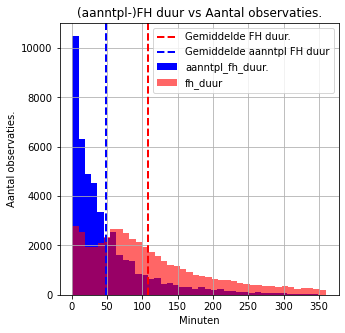

In [109]:
dataset['aanntpl_fh_duur'].hist(figsize=(7,7), bins=40, alpha = 1, color='blue') # hist
dataset['fh_duur'].hist(figsize=(5,5), bins=40,alpha = 0.6, color='red') # hist


plt.axvline(dataset['fh_duur'].mean(), color='red', linestyle='dashed', linewidth=2) # add mean line
plt.axvline(dataset['aanntpl_fh_duur'].mean(), color='blue', linestyle='dashed', linewidth=2) # add mean line

plt.legend(["Gemiddelde FH duur.", "Gemiddelde aanntpl FH duur", "aanntpl_fh_duur.", "fh_duur"], loc="upper right") # legend
plt.title("(aanntpl-)FH duur vs Aantal observaties."), plt.xlabel("Minuten"), plt.ylabel("Aantal observaties.") # title, x & y labels

plt.show()

In het blauw is de fh duur te zien vanaf aanntpl en in het rood de totale fh duur.
De fh duur vanaf aanntpl heeft een exponentiële verdeling. En totale fh duur lijkt een rechts-scheve lognormale verdeeld te zijn.

### Baseline Model

Het is belangrijk om een baseline te hebben. Dit is een rudimentaire voorspelling, die we als lat leggen voor onze andere modellen.
Omdat het meetniveau van de target variabele continue is wordt voor een uiteindelijk een regressie model gebruikt. Voor een baseline voor een regressie model kunnen we een centrummaat zoals het gemiddelde of de mediaan.

##### Het splitsen van de dataset
We splitsen de data op in een train- en testset.

In [110]:
target = 'aanntpl_fh_duur'
X = dataset.drop(target ,axis=1)
y = dataset[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### Baseline model maken en fitten
Als baseline strategy raden we steeds het gemiddelde van onze nieuwe targetkolom, aanntpl_fh_duur.

In [111]:
baseline = DummyRegressor(strategy = 'mean').fit(X_train, y_train)

In [112]:
y_predict = baseline.predict(X_test)

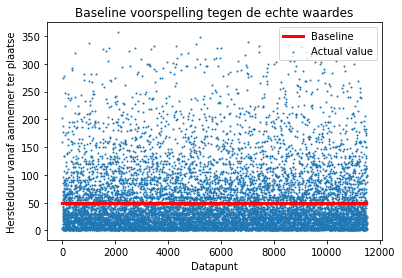

 RMSE Baseline model: 57


In [113]:
plt.plot(y_predict, c='r', linewidth=3)
plt.scatter(x=np.arange(len(X_test)), y=y_test, s=1)

plt.title("Baseline voorspelling tegen de echte waardes")
plt.xlabel("Datapunt")
plt.ylabel("Herstelduur vanaf aannemer ter plaatse")
plt.legend(["Baseline", "Actual value"], loc="upper right")
plt.show()

baseline_rmse = round(mean_squared_error(y_test, y_predict, squared=False))
print(f" RMSE Baseline model: {baseline_rmse}")

Voor elke voorspelling die we doen, door het gemiddelde steeds te raden, zitten we er gemiddeld 57 naast. Dit is een lange tijd maar dat is ook te verwachten, zoals in de grafiek te zien. De spreiding van de punten is erg verdeeld ten opzichte van de rode lijn, onze voorspelling.

### Business Understanding

In het interview met ProRail hebben we gevraagd naar de mogelijk belangrijke attributen die mee kunnen helpen bij het voorspellen van de functiehersteltijd.
Hierop kregen we de volgende paar attributen:
    - Type storing.
    - Tijdstip dat de aannemer ter plaatse er is.
    - Prognose van de storingsduur.
    - Misschien het contractgebied en aannemer.

De laatste twee attributen contractgebied en aannemer houden we voor het eerste model buiten beschouwing.

### Data understanding model 1

Met behulp van de [data dictionary](https://canvas.hu.nl/courses/27143/pages/data?module_item_id=588747) hebben we de volgende kolommen gevonden die overeen lijken te komen met de mogelijk belangrijke attributen volgens ProRail.

Namelijk de volgende kolommen:
-tm_oorz_code, Oorzaak code
-stm_aanntpl_ddt, Aannemer ter plaatse datumtijd
-stm_progfh_in_ddt, Prognose functieherstel datumtijd

We willen hier de volgende features van maken:
- Oorzaak code.
- Dagdeel aannemer ter plaatse (bijv s'ochtends).
- Functieherstel duur prognose vanaf het moment dat de aannemer ter plaatse is.

Eerst maken we een aparte lijst met feature namen waarmee we ons onderzoek voor het eerste model gaan doen.

In [114]:
m1_cols = ['stm_oorz_code', 'stm_aanntpl_ddt', 'stm_progfh_in_ddt', target]

In [115]:
dataset[m1_cols].head(5)

,stm_oorz_code,stm_aanntpl_ddt,stm_progfh_in_ddt,aanntpl_fh_duur
680751,149.0,2015-01-30 18:46:00,2015-01-30 19:45:00,34
760628,221.0,2016-04-20 08:25:39,NaT,235
237571,241.0,2006-08-06 11:27:00,2006-08-06 12:27:00,52
849077,145.0,2017-09-19 13:00:01,2017-09-26 13:31:00,33
304567,181.0,2008-05-06 12:01:00,2008-05-06 12:01:00,6


Oorzaak code lijkt een getal te zijn, in de data dictionary staat beschreven welke oorzaak hoort bij welke code.
De aannemer ter plaatse en de prognose zijn beide een datum-tijdstippen.

### Meetniveaus

In [116]:
pd.DataFrame({'Kolom': m1_cols, 'Meetniveau': ['Nominaal', 'Continue', 'Continue', 'Continue']})

,Kolom,Meetniveau
0,stm_oorz_code,Nominaal
1,stm_aanntpl_ddt,Continue
2,stm_progfh_in_ddt,Continue
3,aanntpl_fh_duur,Continue


#### Centrum-en spreiding maten

Laten we de oorzaak codes grouperen en kijken hoelang een storing gemiddeld duurd bij behorend storingcode.

In [121]:
oorz_grouped = pd.DataFrame({target:dataset.groupby(by='stm_oorz_code').mean()[target], 'count':dataset['stm_oorz_code'].value_counts()}).sort_values(by=target)
oorz_grouped

,aanntpl_fh_duur,count
202.0,2.000000,1
298.0,11.949969,1639
239.0,20.888889,9
299.0,20.949580,238
225.0,25.864333,914
148.0,29.011696,171
134.0,29.500000,10
143.0,32.189127,1306
145.0,34.152654,2129
136.0,35.500000,2


Alle oorzaak codes lijken op eerste blik vergelijkbaar te zijn met de oorzaak codes in de data dictionary.
Wel valt op dat er in de dataset een oorzaak code 999 is. Deze bestaat niet in de data dictionary, en zal later behandelt moeten worden tijdens de data preparation fase.

Laten we de oorzaak codes bekijken die voor de kortste reparatie zorgen.

In [122]:
oorz_grouped.head(5)

,aanntpl_fh_duur,count
202.0,2.000000,1
298.0,11.949969,1639
239.0,20.888889,9
299.0,20.949580,238
225.0,25.864333,914


Oorzaken die vanaf aannemer ter plaatse de kortste hersteltijd hebben:
- 202: Golfslijtage
- 298: Geenonderzoek
- 299: Nietgemeld
- 239: Omhoogwerken/verschuiven
- 225: Doorbranden

En ook de ooraak codes die voor de langste reparatie duur zorgen.

In [123]:
oorz_grouped.tail(5)

,aanntpl_fh_duur,count
206.0,72.333333,6
224.0,79.595238,42
144.0,80.898551,138
189.0,83.700000,10
233.0,105.000000,2


Oorzaken die vanaf aannemer ter plaatse de langste hersteltijd hebben:
- 233: Katterug
- 189: Gladdesporen(bladval/chemicalien)
- 144: Openrijden/kapotrijden
- 224: Overspanning
- 206: Inrijden

### Data preparation model 1

Voordat we de features kunnen analyseren moeten ze eerst aangemaakt worden.
Daarvoor moeten eerst de kolommen stm_oorz_code en stm_progfh_in_ddt opgeschoond worden. De kolom stm_aanntpl_ddt en de target variabele zelf zijn al schoon gemaakt tijdens het data preparation process om de target variabele aan te maken.

##### dtypes
Eerst worden de dtypes gecontroleerd.

In [124]:
df_m1 = dataset.copy()

In [125]:
df_m1[['stm_oorz_code', 'stm_progfh_in_ddt']].dtypes

stm_oorz_code               float64
stm_progfh_in_ddt    datetime64[ns]
dtype: object

Kolom stm_progfh_in_ddt is al van het juiste type gemaakt, tijdens een eerdere fase zijn alle kolommen die te maken hebben met datum-tijd omgezet naar het juiste type.
De kolom stm_oorz_code is van het type float64, de oorzaak code is een getal maar we willen het als label beschouwen omdat er geen volgorde/betekenis zit in het verschil tussen de oorzaak codes zelf.

Oorzaak code wordt daarom categoriaal gemaakt.
Voordat we dit doen laten we ook nog de oorzaak code 999 er uithalen die tijdens de data understanding fase is ontdekt.

In [126]:
(df_m1['stm_oorz_code'] == 999).sum()

4

In [127]:
df_m1 = df_m1[(df_m1['stm_oorz_code'] != 999)] # keep all values other then 999

In [128]:
df_m1['stm_oorz_code'] = df_m1['stm_oorz_code'].astype('category') # convert type to category

NA's controleren

In [129]:
df_m1['stm_oorz_code'].isna().sum()

695

Er zijn een aantal Na waardes als oorzaak code.
Uit de data dictionary blijken er geen andere kolommen te zijn waar we de oorzaak code staat vermeld. We gaan er vanuit dat in deze gevallen er geen oorzaak code is gemeld.
Daarom de Na waardes vervangen door de oorzaakscode 299 : Nietgemeld

In [130]:
df_m1['stm_oorz_code'] = df_m1['stm_oorz_code'].fillna(299.0)

De kolom oorzaak code is nu schoon.

Als volgende stap kan de nieuwe feature aanntpl_dagdeel gemaakt worden.
Hiermee willen we onderzoeken of het tijdstip dat de aannemer ter plaatse was invloed heeft op de betrouwbaarheid van hun prognose.
Hiervoor verdelen we tijdstippen onder in dagdelen:
00:00 t/m 05:00 is nacht
06:00 t/m 11:00 is ochtend
12:00 t/m 17:00 is middag
18:00 t/m 23:00 is avond

In [131]:
df_m1['aanntpl_dagdeel'] = pd.cut(df_m1['stm_aanntpl_ddt'].dt.hour,bins=[0,5,11,17,23],include_lowest=True,labels=['nacht', 'ochtend', 'middag', 'avond'])

In [132]:
df_m1[['stm_aanntpl_ddt', 'aanntpl_dagdeel']].sample(5, random_state=6)

,stm_aanntpl_ddt,aanntpl_dagdeel
154976,2017-05-17 15:02:59,middag
456859,2011-12-16 08:26:00,ochtend
522523,2013-03-28 13:00:00,middag
812951,2016-11-30 12:32:00,middag
393029,2010-06-29 14:30:00,middag


De nieuwe kolom aanntpl_dagdeel is aangemaakt en de dagdelen komen overeen met het tijdstip.

De volgende kolom die aangemaakt moet worden is de prognose van de functieherstel duur vanaf het moment dat de aannemer ter plaatse is, omdat we alleen dit gedeelte voorspellen willen we ook alleen de prognose over dit gedeelte.

Om de duur uit te rekenen nemen we het datum-tijdstip van de functieherstel prognose en halen hier het datum-tijdstip van aannemer ter plaatse af.

Eerst moet de aanntpl_fh_duur_prog gecontroleerd worden op NaN waardes.

In [133]:
df_m1['stm_progfh_in_ddt'].isna().sum()

9392

In [134]:
# kijken of er wel goede tijd datum apart in zit
df_m1[df_m1['stm_progfh_in_ddt'].isna()][['stm_progfh_in_datum', 'stm_progfh_in_tijd']]

,stm_progfh_in_datum,stm_progfh_in_tijd
760628,NaN,00:00:00
287734,NaN,00:00:00
618494,NaN,00:00:00
749343,NaN,00:00:00
405458,NaN,00:00:00
...,...,...
846878,NaN,00:00:00
162116,NaN,00:00:00
478212,NaN,00:00:00
660905,NaN,00:00:00


Ook de aparte kolommen voor datum tijd hebben een NaN waarde of zijn 00:00:00. Deze waardes droppen we.

In [135]:
df_m1.dropna(subset=['stm_progfh_in_ddt'], inplace=True)

Kolom aanntpl_fh_duur_prog aanmaken, de prognose duur vanaf het moment dat de aannemer ter plaatse is.

In [136]:
df_m1['aanntpl_fh_duur_prog'] = ((df_m1['stm_progfh_in_ddt'] - df_m1['stm_aanntpl_ddt']).dt.total_seconds()/60).astype('int')
# ook maken kolom aan wat de totale duur is van de prognose
df_m1['fh_duur_prog'] = ((df_m1['stm_progfh_in_ddt'] - df_m1['stm_sap_meld_ddt']).dt.total_seconds()/60).astype('int')


We willen geen prognoses meereken die 0 of lager zijn op het moment dat de aannemer ter plaatse is.

In [137]:
df_m1 = df_m1[(df_m1['aanntpl_fh_duur_prog'] > 0)]

Ook moet de prognose op een later tijdstip zijn dan dat de aannemer ter plaatse is.

In [138]:
df_m1 = df_m1[(df_m1['stm_progfh_in_ddt'] > df_m1['stm_aanntpl_ddt'])]

Er zijn nu genoeg kolommen schoon om terug te gaan naar data understanding.

### Data understanding model 1

In [139]:
m1_features = ['stm_oorz_code', 'aanntpl_dagdeel', 'aanntpl_fh_duur_prog']

Eerste kijk in de nieuwe feature kolommen tegenover de target.

In [140]:
df_m1[[*m1_features, target]].head()

,stm_oorz_code,aanntpl_dagdeel,aanntpl_fh_duur_prog,aanntpl_fh_duur
680751,149.0,avond,59,34
237571,241.0,ochtend,60,52
849077,145.0,middag,10110,33
515604,298.0,ochtend,5,7
498789,184.0,ochtend,185,175


De nieuwe feature kolommen zien er goed, echter valt wel op dat er een functieherstel duur prognose is van 10110 minuten terwijl de functieherstel duur 33 minuten was.

### Meetniveau's

In [141]:
pd.DataFrame({'Kolom': [*m1_features, target], 'Meetniveau': ['Nominaal', 'Ordinaal', 'Continue', 'Continue'], 'Beschrijving':['Code van de oorzaak', 'Dagdeel wanneer aannemer ter plaatse','Prognose van de functieherstel duur vanaf aannemer ter plaatse', 'Target: Functieherstel duur vanaf aannemer ter plaatse']})

,Kolom,Meetniveau,Beschrijving
0,stm_oorz_code,Nominaal,Code van de oorzaak
1,aanntpl_dagdeel,Ordinaal,Dagdeel wanneer aannemer ter plaatse
2,aanntpl_fh_duur_prog,Continue,Prognose van de functieherstel duur vanaf aann...
3,aanntpl_fh_duur,Continue,Target: Functieherstel duur vanaf aannemer ter...


#### centrum-en spreiding maten


In [142]:
df_m1[m1_features].describe()

,aanntpl_fh_duur_prog
count,3.594700e+04
mean,7.386013e+02
std,2.305387e+04
min,1.000000e+00
25%,2.500000e+01
50%,5.400000e+01
75%,9.100000e+01
max,4.122780e+06


Er lijkt nog iets goed mis met de prognose duur laten we dit eerst verder onderzoeken.

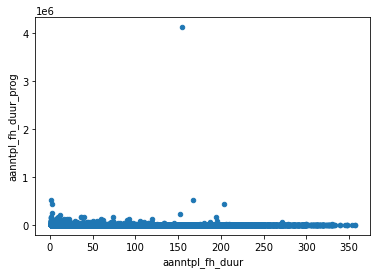

In [143]:
df_m1.plot.scatter(x='aanntpl_fh_duur', y='aanntpl_fh_duur_prog')
plt.show()

Laten we inzoomen op de grafiek door alleen naar prognoses van onder een week te kijken

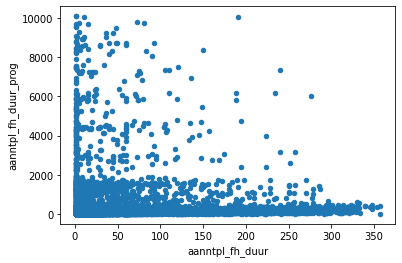

In [147]:
df_m1[df_m1['aanntpl_fh_duur_prog']<1440*7].plot.scatter(x='aanntpl_fh_duur', y='aanntpl_fh_duur_prog')
plt.show()

We zien dat bij relatief lage functieherstel duren vaak bizar hoge prognoses worden opgegeven zoals duizenden minuten wanneer de daadwerkelijke hersteltijd 1 tot enkele minuten duurt.

Hiermee zijn we naar onze product owner gestapt, want het lijkt er op alsof er veel foutieve/onrealistiche prognoses zijn ingevuld.
De productowner liet weten een afwijking van 2 uur teveel te vinden voor daadwerkelijke hersteltijden van 1 minuut en voor een afwijking van 24 uur teveel voor een hersteltijd van 6 uur.
We zijn hierdoor tot de afspraak gekomen om een interpolatie op de data te doen om zo alles boven een lineaire lijn als onzin prognose te beschouwen.

In [148]:
interpolater = interp1d([1, 360], [120, 1440])

Laten we dit afsnij punt bekijken op een scatterplot waar we alleen naar prognoses kijken van onder de 24 uur omdat dit het hoogste punt in onze afsnijding is.

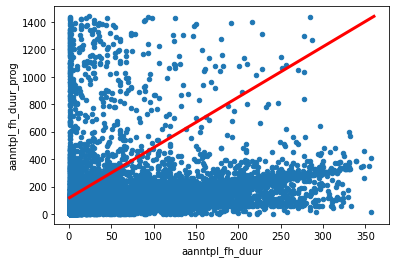

In [154]:
df_m1[df_m1['aanntpl_fh_duur_prog']<1440].plot.scatter(x='aanntpl_fh_duur', y='aanntpl_fh_duur_prog')
plt.plot([1, 360], [120, 1440], c='red', linewidth=3)
plt.show()

In [155]:
df_m1 = df_m1[(df_m1['aanntpl_fh_duur_prog']) < (interpolater(df_m1['aanntpl_fh_duur']))]

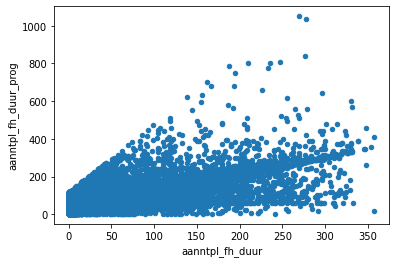

In [157]:
df_m1.plot.scatter(x='aanntpl_fh_duur', y='aanntpl_fh_duur_prog')
plt.show()

Opvalled is dat er nu een duidelijk lineair verband zit tussen de prognose en de daadwerkelijke fh duur vanaf aanntpl.

Nu een groot deel van de foutieve prognoses eruit zijn kunnen we weer verder met het analyseren van de centrums-en spreidingsmaten

In [ ]:
df_m1['aanntpl_fh_duur'].describe()

De centrums-en spreidings maten lijken nu

#### Modeling model 1

In [158]:
features_selection = ['aanntpl_fh_duur_prog']

In [ ]:
dataset_m1 = df_m1[[*features_selection, target]]

In [159]:
X = df_m1['aanntpl_fh_duur_prog'].values.reshape(-1,1)
y = df_m1[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

34.67699438029809

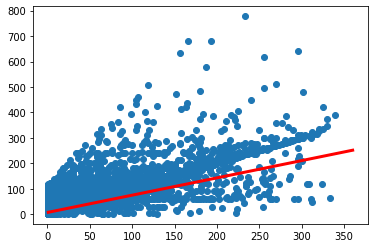

In [210]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_test,y_pred, squared=False)

plt.scatter(y_test, X_test)
line = np.linspace(min(X_train), 360, 100)
plt.plot(line, reg.predict(line),'-r',linewidth=3)
mean_squared_error(y_test,y_pred, squared=False)

In [212]:
[print(f"Aantal polynomen: {i} RMSE", round(mean_squared_error(y_test,make_pipeline(PolynomialFeatures(i),LinearRegression()).fit(X_train,y_train).predict(X_test), squared=False),2)) for i in range(1,10)]

Aantal polynomen: 1 RMSE 34.68
Aantal polynomen: 2 RMSE 33.35
Aantal polynomen: 3 RMSE 33.35
Aantal polynomen: 4 RMSE 33.12
Aantal polynomen: 5 RMSE 33.07
Aantal polynomen: 6 RMSE 33.08
Aantal polynomen: 7 RMSE 35.11
Aantal polynomen: 8 RMSE 38.93
Aantal polynomen: 9 RMSE 44.2


[None, None, None, None, None, None, None, None, None]

[]

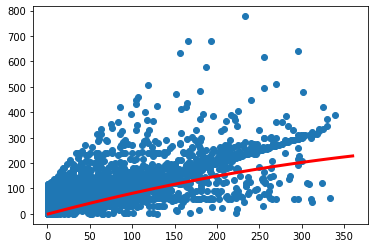

In [214]:
poly = make_pipeline(PolynomialFeatures(2),LinearRegression()).fit(X_train,y_train)
line = np.linspace(min(X_train), 360, 100)

plt.plot(line, poly.predict(line),'-r',linewidth=3)
plt.scatter(y_test, X_test)
plt.plot()